# Imports

In [475]:
from pathlib import Path

import IPython
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from einops import asnumpy, parse_shape, rearrange, reduce
from einops.layers.torch import Rearrange
import librosa

rng = np.random.default_rng()

# Functions

In [476]:
F1 = np.array([697, 770, 852, 941])
F2 = np.array([1209, 1336, 1477, 1633])
tones = {
    "1": (0, 0),
    "2": (0, 1),
    "3": (0, 2),
    "4": (1, 0),
    "5": (1, 1),
    "6": (1, 2),
    "7": (2, 0),
    "8": (2, 1),
    "9": (2, 2),
    "0": (3, 1),
    "*": (3, 0),
    "#": (3, 2),
    "A": (0, 3),
    "B": (1, 3),
    "C": (2, 3),
    "D": (3, 3),
}
SYMBOLS = list("1234567890*#ABCD")
FS = 22_050  # Hz

In [477]:

translate_dict = dict(zip(SYMBOLS, range(len(SYMBOLS))))

def tone(symbol, duration, fs):
    """Generate the sound for symbol with given duration and sampling frequency"""
    inds = tones[symbol]
    f1 = F1[inds[0]]
    f2 = F2[inds[1]]  # get both frequencies for the digit

    t = np.arange(0, duration, 1 / fs)
    return np.cos(2 * np.pi * f1 * t) + np.cos(2 * np.pi * f2 * t)  # calculate signal

def generate_dataset(n_symbols: int=10):
    """
    Generate a dataset of DTMF signals.

    Parameters:
    n_symbols (int): Number of symbols to generate in the dataset.

    Returns:
    list_of_segments (list): List of generated signal segments.
    list_of_symbols (list): List of symbols corresponding to the generated signals.
    """
    list_of_symbols = rng.choice(SYMBOLS, size=n_symbols)
    list_of_segments = list()

    duration = 2048  # samples
    for symbol in list_of_symbols:
        # generate tone
        signal = tone(symbol=symbol, duration=duration / FS, fs=FS)
        # generate silence
        silence = np.zeros(duration)
        # append tone and silence
        list_of_segments.append(signal)

    return list_of_segments, list_of_symbols.tolist()

In [478]:
def plot_waveform(waveform, sr):
    num_frames, = waveform.shape
    time_axis = np.arange(0, num_frames) / sr
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(time_axis, waveform)

## Generate training and testing sets

In [ ]:
N_DATA = 500

X_train, y_train = generate_dataset(N_DATA)
X_test, y_test = generate_dataset(N_DATA)
# Vérifier les 5 premiers labels générés
print(f"Exemple de y_train : {y_train[:5]}")

In [ ]:
from scipy.signal import welch
import numpy as np

def extract_features_welch(signal):
    freqs, Pxx_den = welch(signal, fs=FS, nperseg=512)
    top_freqs = np.argsort(Pxx_den)[-10:]  # Prendre les 10 pics les plus forts
    return Pxx_den[top_freqs]  # Retourner leurs amplitudes

# Transformer les signaux en caractéristiques
X_train_features = np.array([extract_features_welch(signal) for signal in X_train])
X_test_features = np.array([extract_features_welch(signal) for signal in X_test])


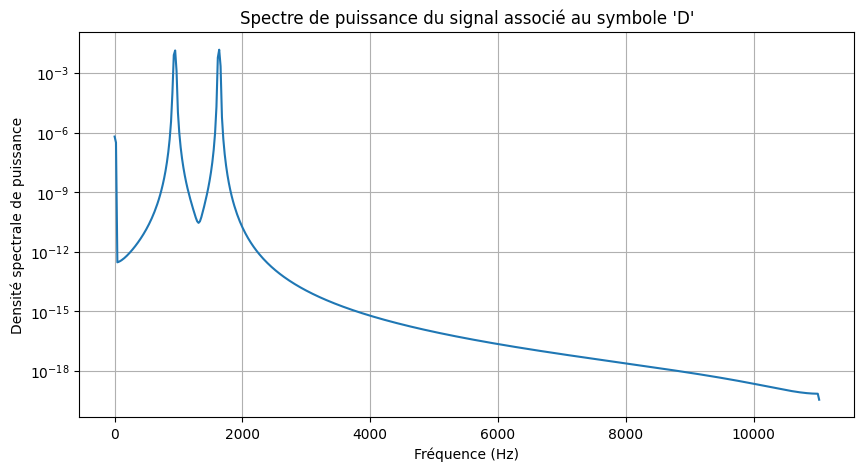

In [481]:
ind = 2  # Par exemple, on prend le 2e signal du dataset
freqs, Pxx_den = welch(X_train[ind], fs=FS, nperseg=1024) 
plt.figure(figsize=(10, 5))
plt.semilogy(freqs, Pxx_den)  # Échelle logarithmique pour mieux voir les pics
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Densité spectrale de puissance')
plt.title(f"Spectre de puissance du signal associé au symbole '{y_train[ind]}'")
plt.grid()
plt.show()


## Display and listen

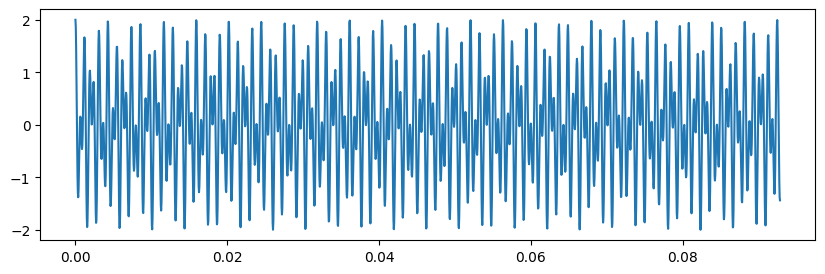

In [482]:
ind = 2
label = y_train[ind]
plot_waveform(X_train[ind], sr=FS)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Normalisation des données (important pour la régression logistique)
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

# Initialisation et entraînement du modèle
model = LogisticRegression(max_iter=1000)
model.fit(X_train_features, y_train)

# Prédictions et évaluation
y_pred = model.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Précision du modèle : {accuracy * 100:.2f}%")


Précision du modèle : 7.00%


In [484]:
IPython.display.Audio(X_train[ind], rate=FS)